<a href="https://colab.research.google.com/github/SofiaSchweitzer/ML4Physics_Summer_School/blob/main/Generative_Unfolding_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import time

import numpy as np
import matplotlib.pyplot as plt

In [2]:
!pip install torchdiffeq

In [3]:
from torchdiffeq import odeint

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

cuda


#### Interesting papers

- An unfolding method based on conditional invertible neural networks (cINN) using iterative training  <br> *Mathias Backes,  Anja Butter, Monica Dunford and Bogdan Malaescu* <br> https://arxiv.org/pdf/2212.08674

- The landscape of unfolding with machine learning <br> *Huetsch et al.* <br> https://arxiv.org/pdf/2404.18807

- Flow Matching for Generative Modeling  <br> *Yaron Lipman, Ricky T. Q. Chen, Heli Ben-Hamu, Maximilian Nickel, Matt Le* <br>
https://arxiv.org/pdf/2210.02747.pdf


We are going to work with a dataset from https://zenodo.org/records/3548091. In particular, we will be looking into three jet-substructure observables of the leading jet, the jet width, the soft-drop mass and the $N_{12}$-subjetiness ratio. The goal is to unfold detector effects and infer $p_\text{data} (x_\text{reco}) \rightarrow p_\text{unfold} (x_\text{part})$ of the 3-dimensional phase space.



Load data

In [5]:
!wget "https://www.dropbox.com/scl/fo/88muusw0kecnxv2644ve6/AG8Ov6PSx7UfxPk328qoP-w?rlkey=stexzrk8t0f0almhrkq32ey3l&st=edyovawd&dl=1"
!unzip "AG8Ov6PSx7UfxPk328qoP-w?rlkey=stexzrk8t0f0almhrkq32ey3l&st=edyovawd&dl=1"

--2025-06-29 14:39:02--  https://www.dropbox.com/scl/fo/88muusw0kecnxv2644ve6/AG8Ov6PSx7UfxPk328qoP-w?rlkey=stexzrk8t0f0almhrkq32ey3l&st=edyovawd&dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uca51bb0f525103f435fad9ecee3.dl.dropboxusercontent.com/zip_download_get/CP42tZCIcDspGZACOqmEoNe6mzbJ1bXZinsH_0Z59IOcRgrDRkVsz9Oab3BL0HY_9O5oEzbm4BIrI8lHaYgjuNoSlroBHm3E9NKOs5ygFyGckg# [following]
--2025-06-29 14:39:03--  https://uca51bb0f525103f435fad9ecee3.dl.dropboxusercontent.com/zip_download_get/CP42tZCIcDspGZACOqmEoNe6mzbJ1bXZinsH_0Z59IOcRgrDRkVsz9Oab3BL0HY_9O5oEzbm4BIrI8lHaYgjuNoSlroBHm3E9NKOs5ygFyGckg
Resolving uca51bb0f525103f435fad9ecee3.dl.dropboxusercontent.com (uca51bb0f525103f435fad9ecee3.dl.dropboxusercontent.com)... 162.125.1.15, 2620:100:6016:15::a27d:10f
Connecting to uca51bb0f525103f435fa

In [6]:
reco_sim = torch.tensor(np.load("reco_MC.npy"), dtype=torch.float)
reco_data = torch.tensor(np.load("reco_data.npy"), dtype=torch.float)
part_sim = torch.tensor(np.load("part_MC.npy"),  dtype=torch.float)
part_data = torch.tensor(np.load("part_data.npy"),  dtype=torch.float)

Build training and test datasets if needed

In [7]:
reco_sim_train, reco_sim_test = reco_sim[:750000], reco_sim[750000:]
reco_data_train, reco_data_test = reco_data[:750000], reco_data[750000:]
part_sim_train, part_sim_test = part_sim[:750000], part_sim[750000:]
part_data_test = part_data[750000:]

We will define some preprocessing functions to apply to the data.

In [8]:
mean = torch.tensor([ 0.1411, -6.9493,  0.6731])
std = torch.tensor([0.0960, 2.2009, 0.2031])

In [9]:
def preprocess(data, mean, std, device="cpu", reverse=False):
    """
    Standardizes or un-standardizes the data.

    Args:
        data (Tensor): The input data tensor.
        mean (Tensor or float): The mean used for standardization.
        std (Tensor or float): The standard deviation used for standardization.
        device (str or torch.device): The device to move the tensor to ('cpu' or 'cuda').
        reverse (bool): If True, reverses the standardization (un-normalize).

    Returns:
        Tensor: Processed data tensor.
    """
    if not reverse:
        data = (data - mean) / std
        return data.to(device)
    else:
        return (data.cpu() * std) + mean

In [10]:
# Clone and preprocess the data to standardize input features with reco-level MC mean and standard deviation.

reco_sim_proc_train = preprocess(reco_sim_train.clone(), mean, std, device=device)
reco_sim_proc_test = preprocess(reco_sim_test.clone(), mean, std, device=device)

reco_data_proc_train = preprocess(reco_data_train.clone(), mean, std, device=device)
reco_data_proc_test = preprocess(reco_data_test.clone(), mean, std, device=device)

part_sim_proc_train = preprocess(part_sim_train.clone(), mean, std, device=device)
part_sim_proc_test = preprocess(part_sim_test.clone(), mean, std, device=device)

### Exercise 1 – Building a CFM in PyTorch

In this first exercise, we will implement a flexible CFM using PyTorch, which will then serve as a core component the generative unfolding algorithm.

The aim is to build a reusable CFM class. This modular design allows us to train and evaluate the CFM multiple times throughout the unfolding process.

#### Structure of the CFM

Your CFM should be implemented as a Python class with the following components:

1. **Initialization (`__init__`)**  
   Here, we define:
   - `dims_in`: the number of input features,
   - `params`: a dictionary of hyperparameters (such as learning rate, network size, and number of training epochs).

2. **Building Network (`init_network`)**  
  Builds a 3-layer MLP that takes [t, x_t, y] and predicts velocity.

3. **Loss Function (`batch_loss`)**  
   Implement a method that computes the weighted CFM-loss
   - input features `x`,
   - condition `y`,
   - sample weights `w`.

4. **Training Loop (`train_cfm`)**  
   Create a training loop that:
   - Accepts part-level simulation (`part_sim`) and reco-level simulation (`reco_sim`) samples,
   - Optionally takes sample weights,
   - Trains the CFM using the Adam optimizer and a learning rate scheduler.

5. **Evaluation (`evaluate`)**  
   Evaluate the CFM on test reco-level data and return samples from unfolded distribution.


Go through the CFM class and fill out the blanks. <br>
Hint: To implement the loss function you need to do the following steps:

1. Randomly draw the timestep $t \sim \mathcal{U}(0,1)$ from a uniform distribution.
2. Sample Gaussian noise $\epsilon \sim \mathcal{N}(0,1)$ .
3. Compute $x(t, x_0, x_1) = x_0  (1-t) + \epsilon t $
4. Call the network as a function of $x(t, x_0, x_1), y $ and $t$
5. Compute the MSE loss between $\frac{dx(t,x_0, x_1)}{dt}$ and the network output.

In [16]:
class CFM(nn.Module):
    def __init__(self, dims_in: int, params: dict):
        """
        Conditional Flow Matching (CFM) model.

        Args:
            dims_in (int): Dimensionality of input features.
            params (dict): Dictionary containing training and model hyperparameters.
                Expected keys:
                    - "hidden_layers": int, size of hidden layers
                    - "lr": float, learning rate
                    - "n_epochs": int, number of training epochs
                    - "batch_size": int, training batch size
                    - "batch_size_sample": int, evaluation batch size
        """
        super().__init__()
        self.dims_in = dims_in
        self.params = params
        self.init_network()
        self.epochs = 0

    def init_network(self):
        """
        Initializes a fully connected feedforward neural network.
        """

        # TODO:
        #    - Build a network to predict the velocity field. What input dimension do you expect?
        #    - Use 3 hidden layers of size `self.params["hidden_layers"]`
        #    - The last layer need to map back to the physical phase space

        self.net = nn.Sequential(
            nn.Linear(2 * self.dims_in + 1, self.params["hidden_layers"]),
            nn.ReLU(),
            nn.Linear(self.params["hidden_layers"], self.params["hidden_layers"]),
            nn.ReLU(),
            nn.Linear(self.params["hidden_layers"], self.params["hidden_layers"]),
            nn.ReLU(),
            nn.Linear(self.params["hidden_layers"], self.dims_in),
        )

    def batch_loss(self, x_part: torch.Tensor, x_reco: torch.Tensor, w: torch.Tensor) -> torch.Tensor:
        """
        Computes the batch-wise flow matching loss.

        Args:
            x_part (Tensor): Particle-level data. Shape: (batch_size, dims_in)
            x_reco (Tensor): Reco-level conditioning data. Shape: (batch_size, dims_in)
            w (Tensor): Sample weights. Shape: (batch_size,)

        Returns:
            Tensor: Scalar loss value.
        """
        dtype = x_part.dtype
        device = x_part.device

        # TODO:
        # Implement the CFM loss
        # Use random interpolation with t ∈ [0, 1]
        # Predict velocity with the network and match to target


        # Sample interpolation scalar t ∈ [0, 1]
        t = torch.rand(size=(x_part.shape[0], 1), dtype=dtype, device=device)

        # Sample Gaussian noise
        noise = torch.randn(size=x_part.shape, dtype=dtype, device=device)

        # Interpolate between x_part and noise
        xt = (1 - t) * x_part + t * noise

        # Predict velocity from interpolated point conditioned on x_reco
        model_pred = self.net(torch.cat((t, xt, x_reco), dim=1))

        # True velocity (noise - data)
        v_target = noise - x_part

        return (w.unsqueeze(-1) * (model_pred - v_target) ** 2).mean()

    def train_unfolder(self, part, reco, weights=None):
        """
        Trains the CFM model.

        Args:
            part (Tensor): Particle-level inputs (target). Shape: (N, dims_in)
            reco (Tensor): Reco-level inputs (conditioning). Shape: (N, dims_in)
            weights (Tensor or None): Optional sample weights. Shape: (N,)
        """
        if weights is None:
            weights = torch.ones((part.shape[0]), device=part.device)

        dataset = torch.utils.data.TensorDataset(part, reco, weights)
        loader = torch.utils.data.DataLoader(
            dataset,
            batch_size=self.params["batch_size"],
            shuffle=True
        )

        optimizer = torch.optim.Adam(self.net.parameters(), lr=self.params["lr"])
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer,
            T_max=len(loader) * self.params["n_epochs"]
        )

        print(f"Training CFM for {self.params['n_epochs']} epochs with lr {self.params['lr']}")
        t0 = time.time()

        for epoch in range(self.params["n_epochs"]):
            losses = []
            for x_part, x_reco, weight in loader:
                self.net.train()

                # TODO: Write training loop

                # Reset optimizer
                optimizer.zero_grad()
                # Calculate batch loss
                loss = self.batch_loss(x_part, x_reco, weight)
                # Backpropagation
                loss.backward()
                # Update optimizer
                optimizer.step()
                # Update step
                scheduler.step()

                losses.append(loss.item())

            if epoch % max(1, self.params["n_epochs"] // 5) == 0:
                print(
                    f"    Epoch {epoch}: Avg loss = {torch.tensor(losses).mean():.4f}, Time = {round(time.time() - t0, 1)}s"
                )

            self.epochs += 1

        print(f"Finished training CFM in {round(time.time() - t0, 1)} seconds")

    def sample(self, x_reco: torch.Tensor) -> torch.Tensor:
        """
        Samples particle-level data conditioned on reco-level input.

        Args:
            x_reco (Tensor): Reco-level conditioning input. Shape: (N, dims_in)

        Returns:
            Tensor: Generated particle-level output. Shape: (N, dims_in)
        """
        dtype = x_reco.dtype
        device = x_reco.device

        noise = torch.randn(x_reco.size(0), self.dims_in, device=device, dtype=dtype)

        def net_wrapper(t, x_t):
            # Expand t to batch size and evaluate network at each time step
            t_expanded = t * torch.ones_like(x_t[:, [0]], dtype=dtype, device=device)
            return self.net(torch.cat([t_expanded, x_t, x_reco], dim=1))

        # Integrate velocity field from t=1 to t=0
        x_t = odeint(
            net_wrapper,
            noise,
            torch.tensor([1.0, 0.0], dtype=dtype, device=device),
            rtol=1e-3, atol=1e-5
            )

        return x_t[-1]  # Sample at t = 0

    def evaluate(self, reco: torch.Tensor) -> torch.Tensor:
        """
        Evaluates the model on reco-level input to generate unfolded samples.

        Args:
            reco (Tensor): Reco-level inputs. Shape: (N, dims_in)

        Returns:
            Tensor: Unfolded particle-level predictions. Shape: (N, dims_in)
        """
        predictions = []
        with torch.no_grad():
            for batch in torch.split(reco, self.params["batch_size_sample"]):
                unfold_cfm = self.sample(batch).detach()
                predictions.append(unfold_cfm)
        return torch.cat(predictions)


To iteratively update the prior particle-level distribution, we will also need a classifier. As we have already implemted one in the first tutorial, we can just recycle the `Classifier` class.

In [37]:
class Classifier(nn.Module):
    def __init__(self, dims_in, params):
        """
        Initializes the classifier model.

        Args:
            dims_in (int): Dimensionality of input features.
            params (dict): Dictionary of model and training hyperparameters.
        """
        super().__init__()
        self.dims_in = dims_in
        self.params = params
        self.init_network()

    def init_network(self):
        """
        Initializes a fully connected feedforward neural network.
        """
        self.net = nn.Sequential(
            nn.Linear(self.dims_in, self.params["hidden_layers"]),
            nn.ReLU(),
            nn.Linear(self.params["hidden_layers"], self.params["hidden_layers"]),
            nn.ReLU(),
            nn.Linear(self.params["hidden_layers"], self.params["hidden_layers"]),
            nn.ReLU(),
            nn.Linear(self.params["hidden_layers"], 1),
        )

    def batch_loss(self, x, y, w):
        """
        Computes the weighted BCE loss for a batch.

        Args:
            x (Tensor): Input features.
            y (Tensor): Labels (0 or 1).
            w (Tensor): Sample weights.

        Returns:
            Tensor: Scalar loss value.
        """
        pred = self.net(x).squeeze()
        loss = torch.nn.BCEWithLogitsLoss(weight=w)(pred, y)
        return loss

    def train_classifier(self,
                         data_true,
                         data_fake,
                         weights_true=None,
                         weights_fake=None):
        """
        Trains the classifier on provided true (y=1) and fake (y=0) data.

        Args:
            data_true (Tensor): Data with label 1.
            data_fake (Tensor): Data with label 0.
            weights_true (Tensor): Optional weights for true data.
            weights_fake (Tensor): Optional weights for fake data.
        """

        device = data_true.device
        dtype = data_true.dtype

        if weights_true is None:
            weights_true = torch.ones((data_true.shape[0]), device=device, dtype=dtype)

        if weights_fake is None:
            weights_fake = torch.ones((data_fake.shape[0]), device=device, dtype=dtype)

        loader_true = torch.utils.data.DataLoader(
            torch.utils.data.TensorDataset(data_true, weights_true),
            batch_size=self.params["batch_size"], shuffle=True,
            )

        loader_fake = torch.utils.data.DataLoader(
            torch.utils.data.TensorDataset(data_fake, weights_fake),
            batch_size=self.params["batch_size"], shuffle=True,
            )

        optimizer = torch.optim.Adam(self.net.parameters(), lr=self.params["lr"])
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer=optimizer,
            max_lr=self.params.get("max_lr", 3 * self.params["lr"]),
            epochs=self.params["n_epochs"],
            steps_per_epoch=min(len(loader_true), len(loader_fake)))

        print(f"Training classifier for {self.params['n_epochs']} epochs with lr {self.params['lr']}")
        t0 = time.time()

        for epoch in range(self.params["n_epochs"]):
            losses = []
            for (x_true, w_true), (x_fake, w_fake) in zip(loader_true, loader_fake):
                self.net.train()
                label_true = torch.ones((x_true.shape[0]), device=device, dtype=dtype)
                label_fake = torch.zeros((x_fake.shape[0]), device=device, dtype=dtype)

                optimizer.zero_grad()
                loss = self.batch_loss(x_true, label_true, w_true)
                loss += self.batch_loss(x_fake, label_fake, w_fake)
                loss.backward()
                optimizer.step()
                scheduler.step()
                losses.append(loss.item())

            if epoch % max(1, self.params["n_epochs"] // 5) == 0:
                print(f"    Epoch {epoch}: Avg loss = {torch.tensor(losses).mean():.4f}, Time = {round(time.time() - t0, 1)}s")

        print(f"Training finished in {round(time.time() - t0, 1)} seconds.")

    def evaluate(self, data, return_weights=True):
        """
        Evaluates the classifier.

        Args:
            data (Tensor): Input data.
            return_weights (bool): If True, returns likelihood ratios (exp(logits)).

        Returns:
            Tensor: Predicted weights or probabilities.
        """
        predictions = []
        with torch.no_grad():
            for batch in torch.split(data, self.params["batch_size_sample"]):
                pred = self.net(batch).squeeze().detach()
                predictions.append(pred)
        predictions = torch.cat(predictions)
        return predictions.exp().clip(0, 30) if return_weights else torch.sigmoid(predictions)

As we are going to need a lot of plots showing generated distributions or reweighted distributions we will define a plot function

In [18]:
FONTSIZE = 14

def plot_generated_distribution(x_part,
                                x_reco,
                                x_unfolded,
                                weights=None,
                                bins=50,
                                name=None):
    """
    Plots the distribution of a single feature for:
      - (weighted) particle-level data,
      - (weighted) reco-level data,
      - (weighted) unfolded data

    Args:
        x_part (Tensor): part-level data of shape [N].
        x_reco (Tensor): reco-level data of shape [N].
        weights (Tensor): Weights of shape [N].
        bins (int): Number of bins in the histogram.
    """
    # Plot
    plt.figure(figsize=(6, 4))
    plt.hist(x_reco, bins=bins, label="reco ", density=True, color="royalblue", histtype="step")
    plt.hist(x_unfolded, bins=bins, weights=weights, label="unfolded", density=True, color="darkred", histtype="step")
    plt.hist(x_part, bins=bins, label="part", density=True, color="black", histtype="step", weights=weights)

    plt.xlabel(r"${%s}$" % name,
               fontsize=FONTSIZE)

    plt.ylabel("Density",
              fontsize=FONTSIZE)

    plt.legend(frameon=False, fontsize=FONTSIZE)
    plt.tight_layout()
    plt.show()



def plot_reweighted_distribution(true,
                                 fake,
                                 weights,
                                 bins=50,
                                name=None):
    """
    Plots the distribution of a single feature for:
      - true data,
      - fake data (raw),
      - fake data reweighted by weights.

    Args:
        true (Tensor): True data of shape [N, ].
        fake (Tensor): Fake data of shape [N, ].
        weights (Tensor): Weights for fake data, shape [N].
        bins (int): Number of bins in the histogram.
    """
    # Plot
    plt.figure(figsize=(6, 4))
    plt.hist(fake, bins=bins, label="Sim ", density=True, color="royalblue", histtype="step")
    plt.hist(fake, bins=bins, weights=weights, label="Sim (reweighted)", density=True, color="darkred", histtype="step")
    plt.hist(true, bins=bins, label="Data", density=True, color="black", histtype="step")

    plt.xlabel(r"${%s}$" % name,
               fontsize=FONTSIZE)

    plt.ylabel("Density",
              fontsize=FONTSIZE)

    plt.legend(frameon=False, fontsize=FONTSIZE)
    plt.tight_layout()
    plt.show()

In [61]:
# Define cfm parameteres

cfm_params = {"hidden_layers": 128,
              "lr": 1.e-3,
              "n_epochs" : 20,
              "batch_size" : 8192,
              "batch_size_sample": 10000}

# Useful plotting variables
n_features = reco_sim_test.shape[1]

binning = [torch.linspace(0, 0.6, 40 + 1),
           torch.linspace(-13, -2, 40 + 1),
           torch.linspace(0.1, 1.1, 40 + 1)]

names = [r"\text{Jet width } w",
         r"\text{Groomed mass }\log \rho",
         r"\text{N-subjettiness ratio } \tau_{21}"]

### Exercise 2 - Single Iteration Generative Unfolding (Unfolder)

To get a better understanding of generative unfolding we will start by doing the first iteration explicitly. For one iteration implement the following steps:

1. Train a cfm network to learn to sample from the posterior distribution $p(x_{\text{part}} | x_{\text{reco}})$

In [20]:
# Build the generative unfolder
unfolder = CFM(3, cfm_params).to(device)

# Train the generative unfolder using part-level simulation and reco-level simulation
unfolder.train_unfolder(part_sim_proc_train, reco_sim_proc_train)

Training CFM for 20 epochs with lr 0.001
    Epoch 0: Avg loss = 1.2048, Time = 14.4s
    Epoch 4: Avg loss = 0.8207, Time = 68.3s
    Epoch 8: Avg loss = 0.8027, Time = 122.4s
    Epoch 12: Avg loss = 0.7977, Time = 176.0s
    Epoch 16: Avg loss = 0.7941, Time = 230.3s
Finished training CFM in 270.5 seconds


2. Before we unfold reco-level data we want to ensure that we have closure on simulation. Therefore, start with unfolding the reco-level simulations $x_\text{reco} \sim p_\text{sim}(x_\text{reco})$.

In [21]:
# Evaluate reco-level data
unfolded_sim_test = unfolder.evaluate(reco_sim_proc_test)

# reverse preprocess
unfolded_sim_test = preprocess(unfolded_sim_test, mean, std, device=device, reverse=True)

3. Plot reco_sim_test, unfolded_sim_test and part_sim_test

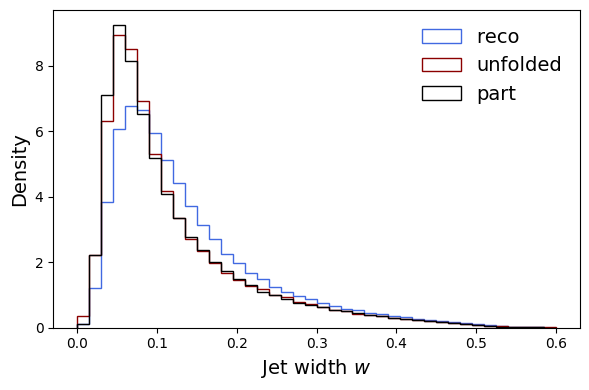

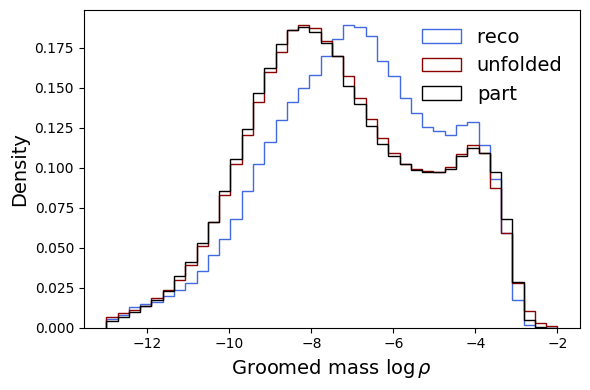

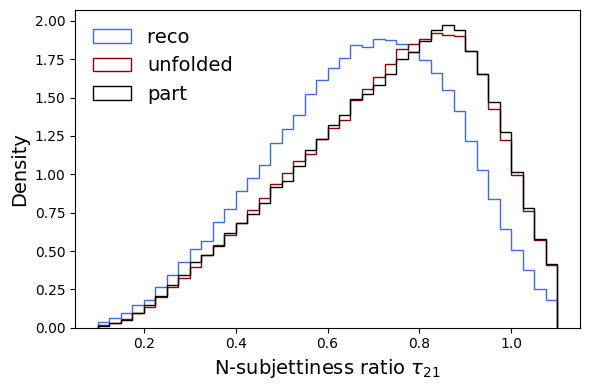

In [22]:
for i in range(n_features):
  plot_generated_distribution(part_sim_test[: , i],
                              reco_sim_test[:, i],
                              unfolded_sim_test[:, i],
                              bins=binning[i],
                              name = names[i])

4. Unfold $x_\text{reco} \sim p_\text{data}(x_\text{reco})$

In [23]:
# Evaluate reco-level data
unfolded_data_train = unfolder.evaluate(reco_data_proc_train)
unfolded_data_test = unfolder.evaluate(reco_data_proc_test)

# reverse preprocess
unfolded_data_test = preprocess(unfolded_data_test, mean, std, device=device, reverse=True)

5. Plot reco_data_test, unfolded_data_test and part_data_test

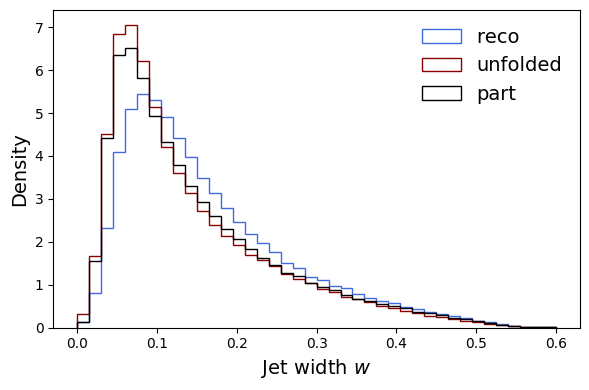

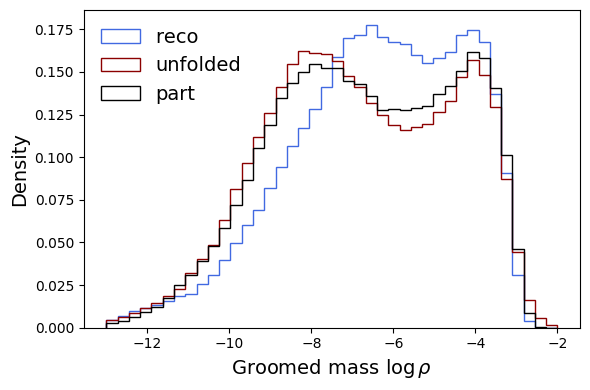

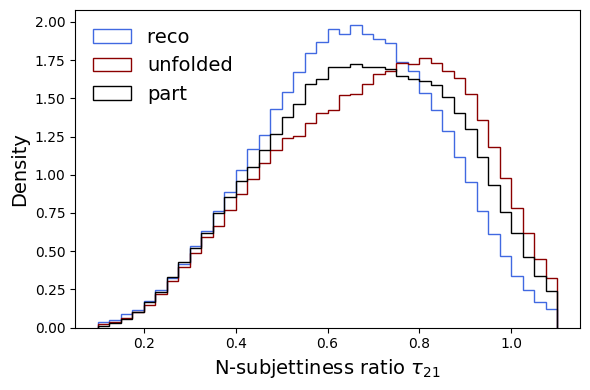

In [24]:
for i in range(n_features):
  plot_generated_distribution(part_data_test[: , i],
                              reco_data_test[:, i],
                              unfolded_data_test[:, i],
                              bins=binning[i],
                              name = names[i])

What do you observe?

### Exercise 3 - Single Iteration Generative Unfolding (Classifier)
Implement the following steps:

1. To start the first iteration we will train a classifier between $p_\text{unfold}(x_\text{part})$ and $p_\text{sim}(x_\text{part})$.

In [43]:
classifier_params = {"hidden_layers": 64,
                     "lr": 1.e-3,
                     "n_epochs" : 10,
                     "batch_size" : 512,
                     "batch_size_sample": 2000}

# Intialize classifier
classifier = Classifier(3, classifier_params).to(device)
classifier.train_classifier(unfolded_data_train, part_sim_proc_train)

Training classifier for 10 epochs with lr 0.001
    Epoch 0: Avg loss = 1.3712, Time = 16.3s
    Epoch 2: Avg loss = 1.3584, Time = 49.7s
    Epoch 4: Avg loss = 1.3541, Time = 83.5s
    Epoch 6: Avg loss = 1.3511, Time = 117.1s
    Epoch 8: Avg loss = 1.3488, Time = 150.1s
Training finished in 167.1 seconds.


2. Evaluate classifer $w_\theta (x_\text{part})$ with $x_\text{part} \sim p_\text{sim}(x_\text{part})$

In [44]:
w_part_train = classifier.evaluate(
    data=part_sim_proc_train,
)
w_part_test = classifier.evaluate(
    data=part_sim_proc_test,
)

3. Check if you classifier learned the likelihood ratio correctly by plotting $p_\text{unfold}(x_\text{part})$, $p_\text{sim}(x_\text{part})$ and $w_\theta(x_\text{part}) p_\text{sim}(x_\text{part})$.

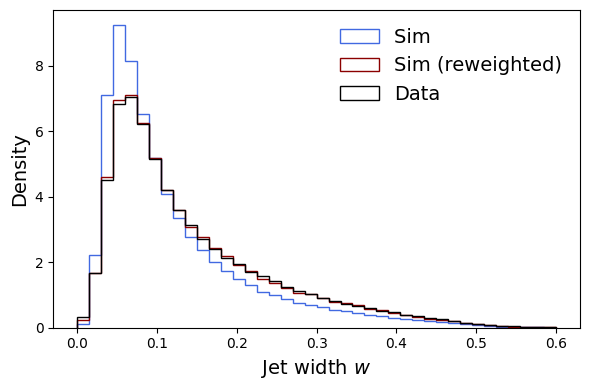

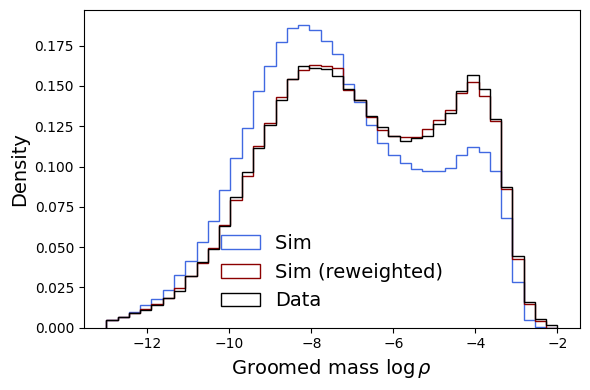

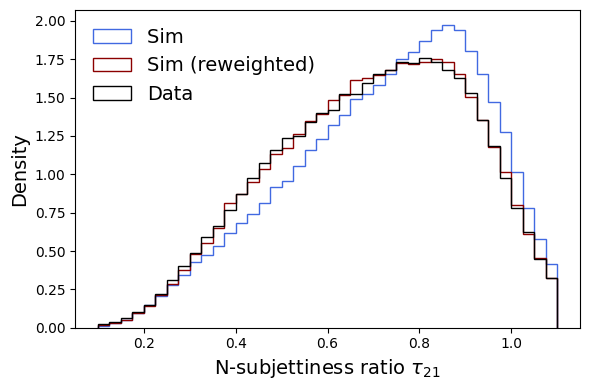

In [46]:
for i in range(n_features):
  plot_reweighted_distribution(fake=part_sim_test[: , i],
                              true=unfolded_data_test[:, i],
                              weights=w_part_test.cpu(),
                              bins=binning[i],
                              name = names[i])

### Exercise 4 - Iterative Generative Unfolding
Now that we have walked through a single iteration of Generative Unfolding step-by-step, it's time to automate the full iterative unfolding procedure.
Add all indivual steps to an iterative loop. For later iterations $(i > 0 )$ you can use the pretrained unfolder from the first iteration and reduce the number of epochs to fine-tune the posterior estimation with the updated simulations.

Starting with iteration 0
Building CFM
Training unfolder
Training CFM for 20 epochs with lr 0.001
    Epoch 0: Avg loss = 1.2105, Time = 14.2s
    Epoch 4: Avg loss = 0.8197, Time = 69.2s
    Epoch 8: Avg loss = 0.8038, Time = 124.8s
    Epoch 12: Avg loss = 0.7967, Time = 179.4s
    Epoch 16: Avg loss = 0.7954, Time = 235.0s
Finished training CFM in 275.9 seconds
Evaluating unfolder on test simulation
Plotting unfolded simulation


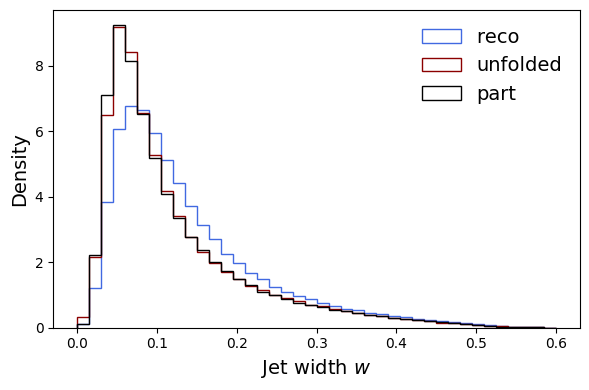

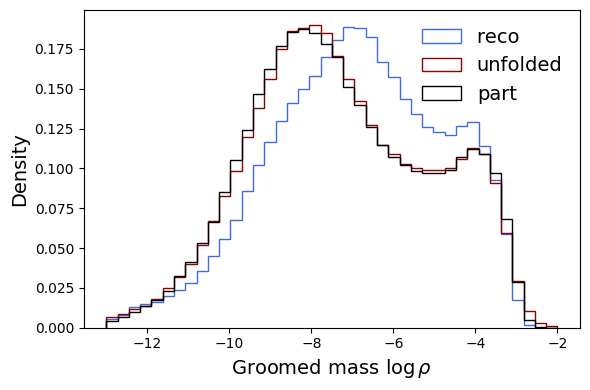

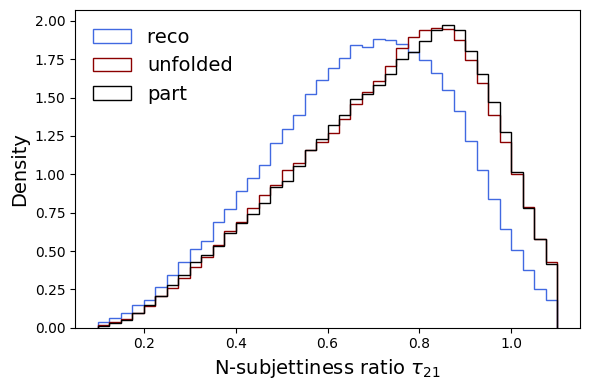

Evaluating unfolder on test data
Plotting unfolded data


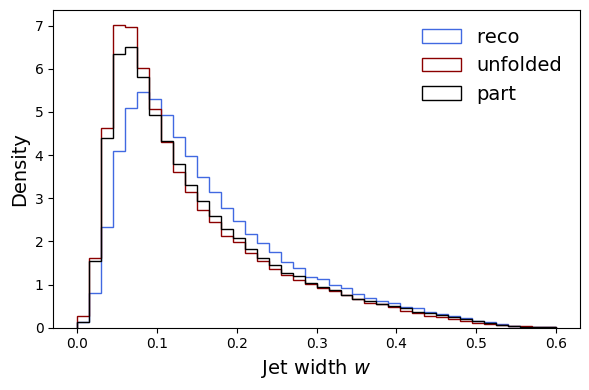

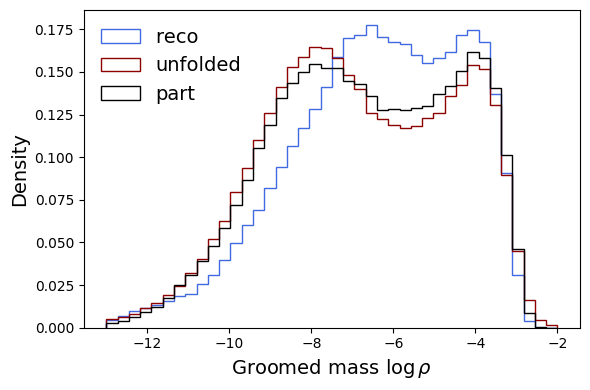

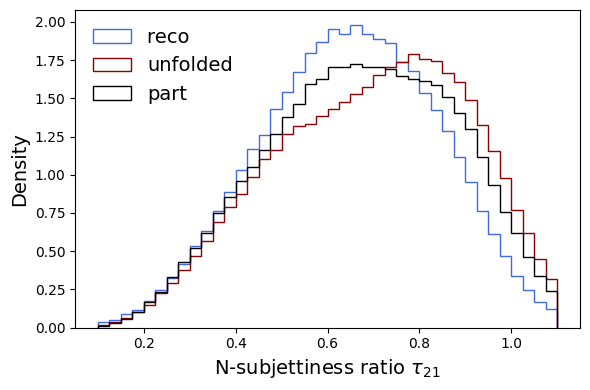

Starting with iteration 1
Building classifier
Training classifier
Training classifier for 10 epochs with lr 0.001
    Epoch 0: Avg loss = 1.3709, Time = 16.2s
    Epoch 2: Avg loss = 1.3561, Time = 49.5s
    Epoch 4: Avg loss = 1.3517, Time = 82.6s
    Epoch 6: Avg loss = 1.3494, Time = 114.9s
    Epoch 8: Avg loss = 1.3473, Time = 148.4s
Training finished in 167.7 seconds.
Evaluating classifier
Plotting reweighted simulation.


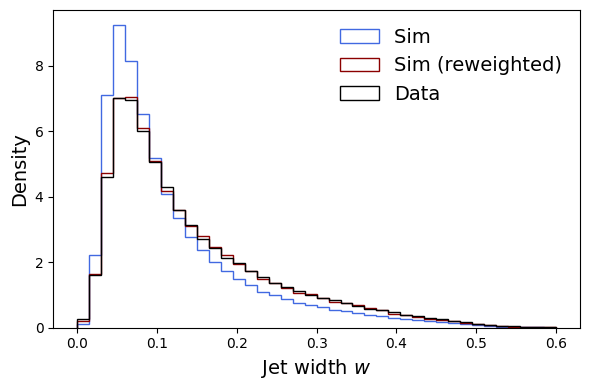

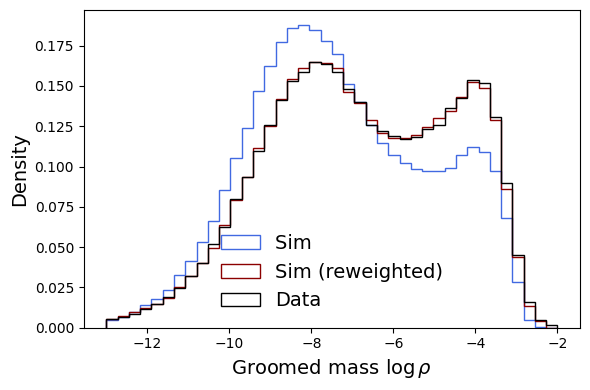

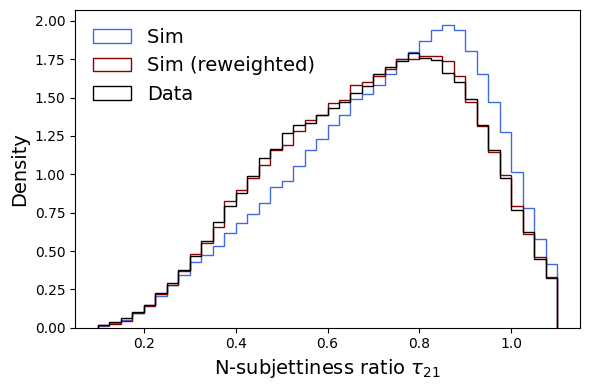

Reducing number of epochs of the unfolder.
Training unfolder
Training CFM for 5 epochs with lr 0.001
    Epoch 0: Avg loss = 0.7924, Time = 16.5s
    Epoch 1: Avg loss = 0.7818, Time = 31.0s
    Epoch 2: Avg loss = 0.7785, Time = 46.0s
    Epoch 3: Avg loss = 0.7782, Time = 60.5s
    Epoch 4: Avg loss = 0.7789, Time = 74.5s
Finished training CFM in 74.5 seconds
Evaluating unfolder on test simulation
Plotting unfolded simulation


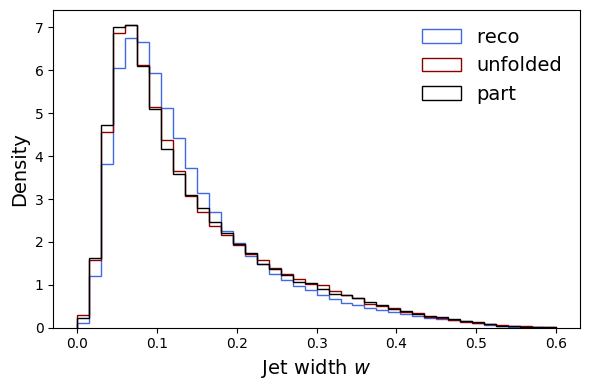

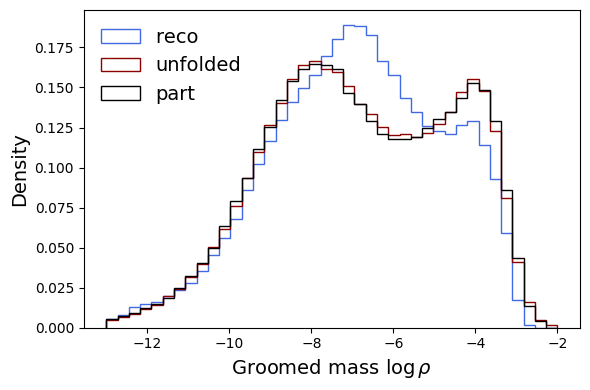

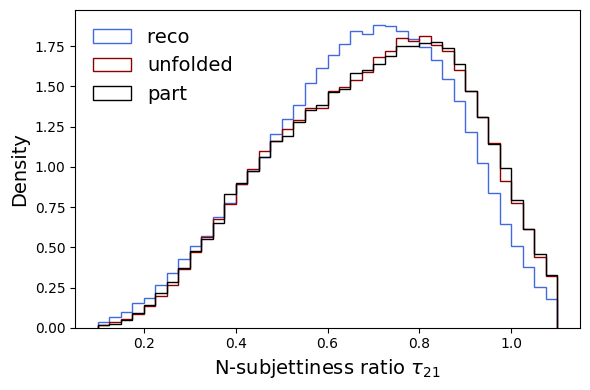

Evaluating unfolder on test data
Plotting unfolded data


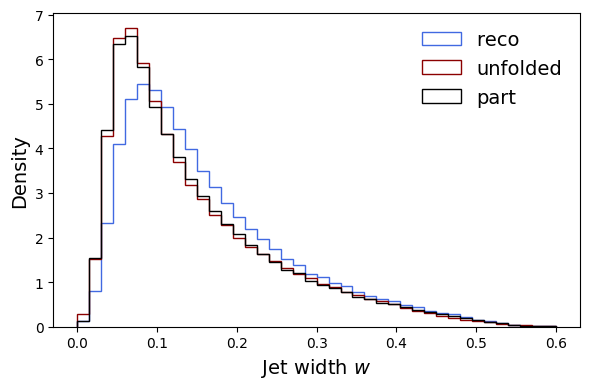

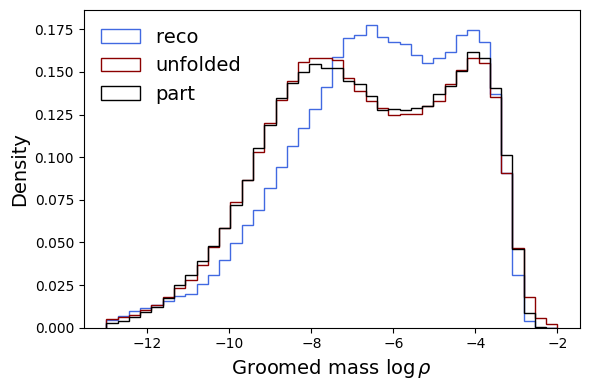

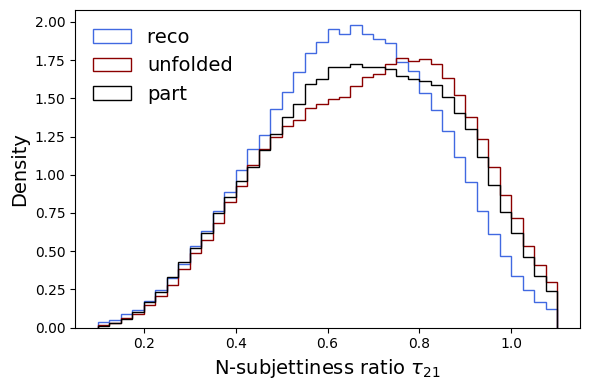

Starting with iteration 2
Building classifier
Training classifier
Training classifier for 10 epochs with lr 0.001
    Epoch 0: Avg loss = 1.3810, Time = 17.0s
    Epoch 2: Avg loss = 1.3808, Time = 49.7s
    Epoch 4: Avg loss = 1.3805, Time = 82.8s
    Epoch 6: Avg loss = 1.3800, Time = 116.0s
    Epoch 8: Avg loss = 1.3788, Time = 149.2s
Training finished in 165.5 seconds.
Evaluating classifier
Plotting reweighted simulation.


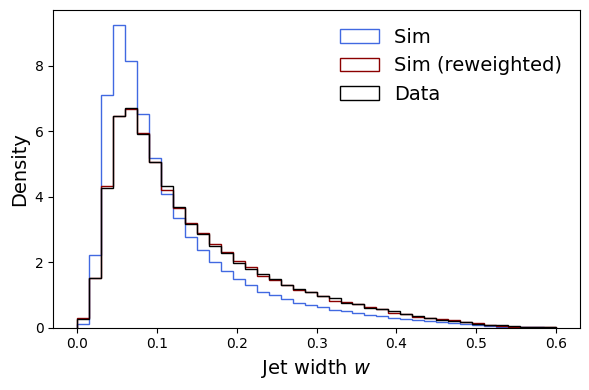

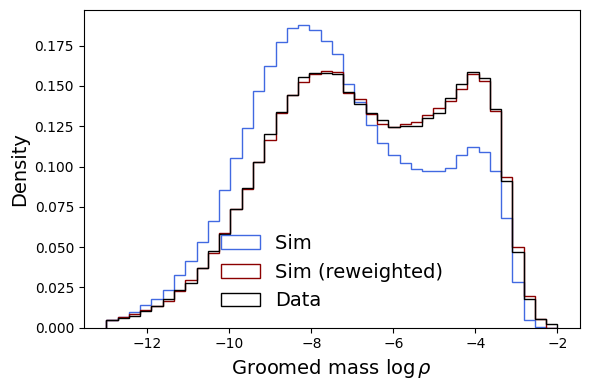

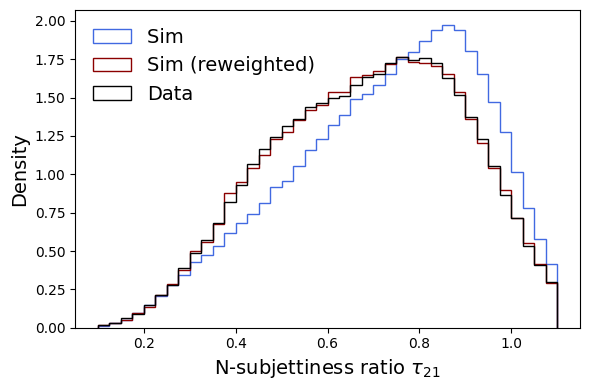

Reducing number of epochs of the unfolder.
Training unfolder
Training CFM for 5 epochs with lr 0.001
    Epoch 0: Avg loss = 0.7904, Time = 13.7s
    Epoch 1: Avg loss = 0.7834, Time = 27.6s
    Epoch 2: Avg loss = 0.7839, Time = 41.9s
    Epoch 3: Avg loss = 0.7862, Time = 55.8s
    Epoch 4: Avg loss = 0.7801, Time = 69.7s
Finished training CFM in 69.7 seconds
Evaluating unfolder on test simulation
Plotting unfolded simulation


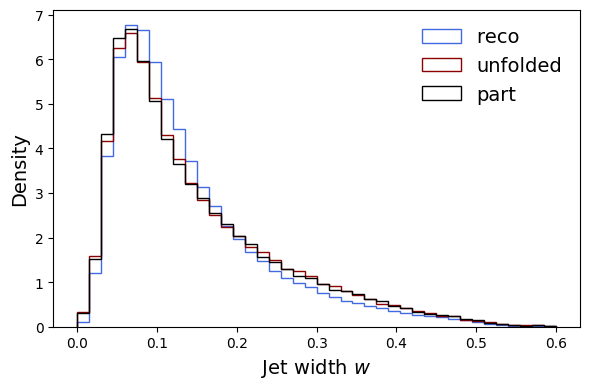

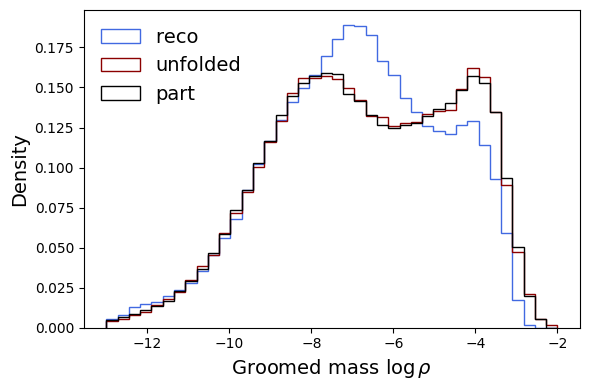

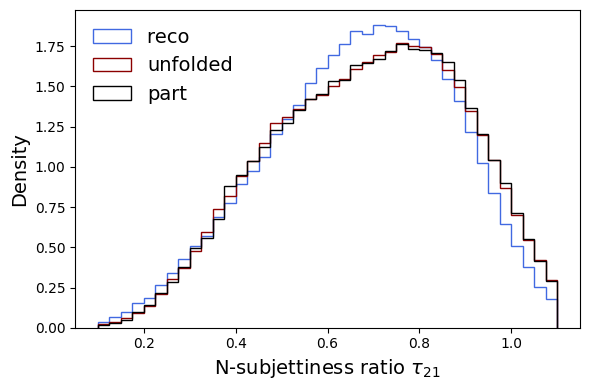

Evaluating unfolder on test data
Plotting unfolded data


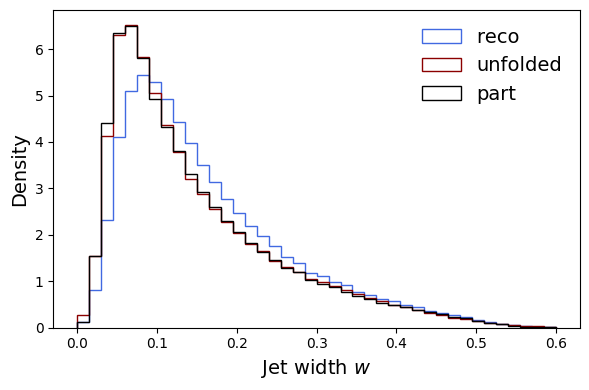

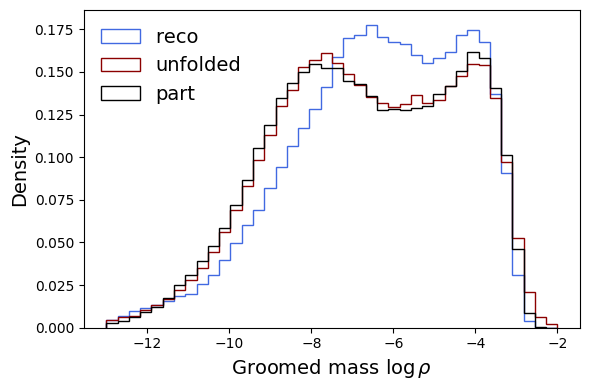

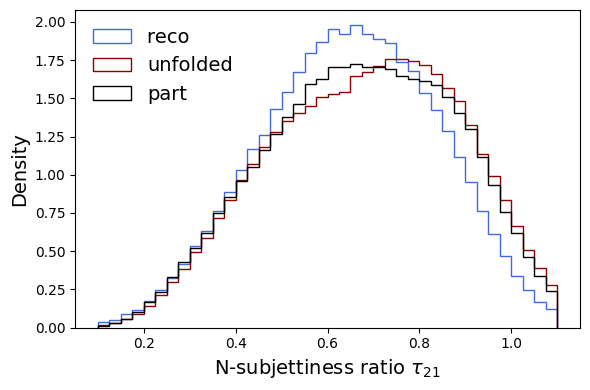

In [62]:
iterations = 3

w_part_train = torch.ones((part_sim_train.size(0)), dtype=torch.float, device=device )
w_part_test = torch.ones((part_sim_test.size(0)), dtype=torch.float, device=device )
for i in range(iterations):
    print(f"Starting with iteration {i}")
    if i == 0:
      print("Building CFM")
      unfolder = CFM(3, cfm_params).to(device)

    if i > 0:

      print("Building classifier")
      classifier = Classifier(
          3,
          classifier_params).to(device)

      print("Training classifier")
      classifier.train_classifier(
          unfolded_data_train,
          part_sim_proc_train,
          weights_fake=w_part_train)

      print("Evaluating classifier")
      w_part_train *= classifier.evaluate(
      data=part_sim_proc_train,
      )
      w_part_test *= classifier.evaluate(
      data=part_sim_proc_test,
      )

      print("Plotting reweighted simulation.")
      for i in range(n_features):
        plot_reweighted_distribution(
            fake=part_sim_test[: , i],
            true=unfolded_data_test[:, i],
            weights = w_part_test.cpu(),
            bins=binning[i],
            name = names[i])

      print(f"Reducing number of epochs of the unfolder.")
      unfolder.params["n_epochs"] = 5

    print("Training unfolder")
    unfolder.train_unfolder(part_sim_proc_train, reco_sim_proc_train, weights=w_part_train)

    print("Evaluating unfolder on test simulation")
    unfolded_sim_test = unfolder.evaluate(reco_sim_proc_test)
    unfolded_sim_test = preprocess(unfolded_sim_test, mean, std, device=device, reverse=True)
    print("Plotting unfolded simulation")
    for i in range(n_features):
      plot_generated_distribution(
          part_sim_test[: , i],
          reco_sim_test[:, i],
          unfolded_sim_test[:, i],
          weights=w_part_test.cpu(),
          bins=binning[i],
          name = names[i])

    print("Evaluating unfolder on test data")
    unfolded_data_train = unfolder.evaluate(reco_data_proc_train)
    unfolded_data_test = unfolder.evaluate(reco_data_proc_test)
    unfolded_data_test = preprocess(unfolded_data_test, mean, std, device=device, reverse=True)

    print("Plotting unfolded data")
    for i in range(n_features):
      plot_generated_distribution(
          part_data_test[: , i],
          reco_data_test[:, i],
          unfolded_data_test[:, i],
          bins=binning[i],
          name = names[i])